In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow
from matplotlib.colors import Normalize
from scipy import stats as sps

import pandas as pd

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import common
import amc

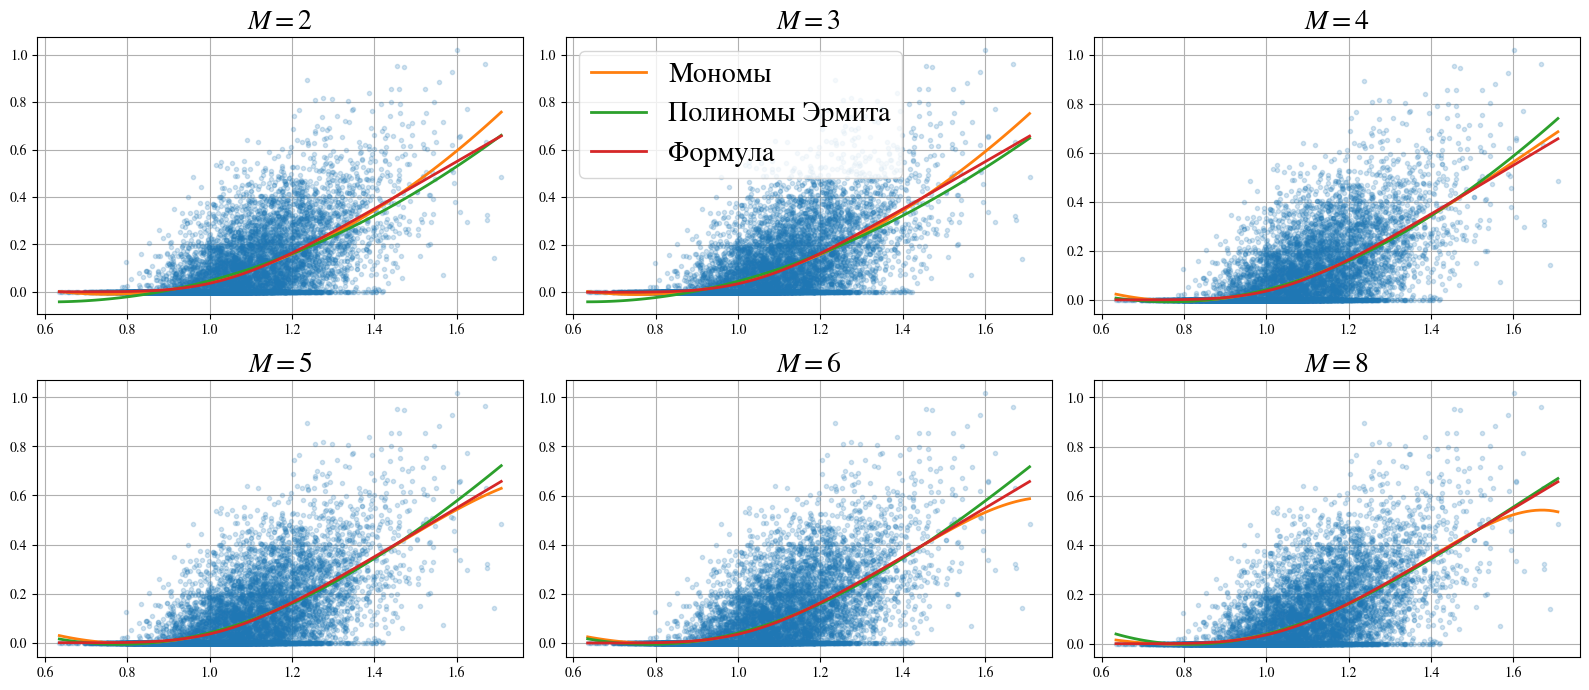

In [4]:
T = 1
nt = 104
nsim = 10000
tn = np.linspace(0, T, nt + 1)

S = 1
sigma = 0.2
r = 0.1
strike = S * np.exp(r * T)


spots = common.sample_gbm(tn, nsim, S, r, sigma)
X = spots[nt // 2]
Y = np.exp(-r * 0.5 * T) * (spots[-1] - strike).clip(0.0)

xx = np.linspace(X.min(), X.max(), 100)
true = common.get_BS_call_price(xx, r, sigma, strike, 0.5 * T)

degrees = [2, 3, 4, 5, 6, 8]

fig, ax = plt.subplots(2, 3, figsize=(16, 7))
ax = ax.reshape(-1)

predicts = []
predictsh = []
for i, degree in enumerate(degrees): 
    model = amc.PolynomialRegression(degree)
    model.fit(X, Y)

    model_hermit = amc.HermiteRegression(degree, alpha=0.1)
    model_hermit.fit(X, Y)

    
    predict = model.predict(xx)
    predict_hermit = model_hermit.predict(xx)
    
    predicts.append(predict)
    predictsh.append(predict_hermit)
    ax[i].plot(X, Y, '.', alpha=0.2)
    ax[i].plot(xx, predict, lw=2, label='Мономы')
    ax[i].plot(xx, predict_hermit, lw=2, label='Полиномы Эрмита')
    ax[i].plot(xx, true, lw=2, label='Формула')
    #ax[i].legend(fontsize=15)
    ax[i].grid()
    ax[i].set_title(rf"$M={degree}$", fontsize=20)
ax[1].legend(fontsize=20)
fig.tight_layout()
# fig.savefig('../12_figs/regression_based_mc.jpg')
plt.show()

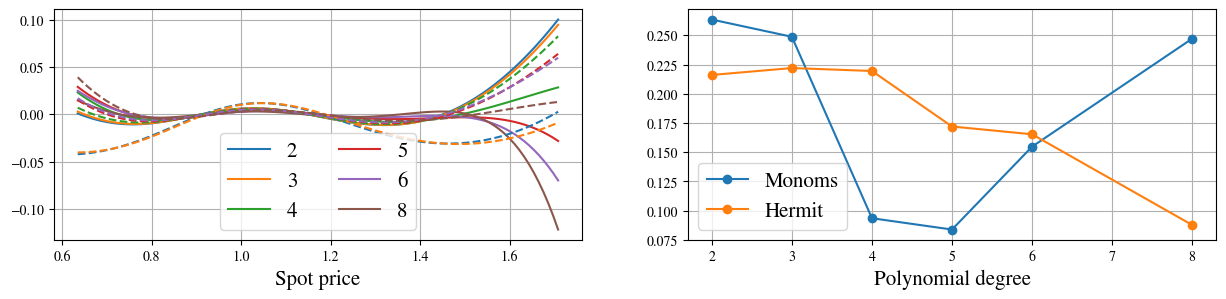

In [30]:
predicts = np.array(predicts)
predictsh = np.array(predictsh)

errors = (predicts - true).T
errorsh = (predictsh - true).T

fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ax[0].plot(xx, errors)
ax[0].set_prop_cycle(None)
ax[0].plot(xx, errorsh, '--')
ax[0].legend(degrees, ncols=2, fontsize=15)
ax[0].grid()
ax[0].set_xlabel("Spot price", fontsize=15)
ax[1].plot(degrees, np.linalg.norm(errors, axis=0), '-o')
ax[1].plot(degrees, np.linalg.norm(errorsh, axis=0), '-o')
ax[1].grid()
ax[1].set_xlabel("Polynomial degree", fontsize=15)
ax[1].legend(['Monoms', 'Hermit'], fontsize=15)
plt.show()

In [163]:
from scipy.interpolate import make_lsq_spline, BSpline, make_smoothing_spline

In [116]:
knots = np.quantile(X, np.linspace(0, 1, 20))
knots = np.r_[knots[0], knots[0], knots[0], knots, knots[-1], knots[-1], knots[-1]]
index = np.argsort(X)
spline = make_lsq_spline(X[index], Y[index], knots, k=3)

In [191]:
spline_smooth = make_smoothing_spline(X[index],  Y[index], lam=0.1)

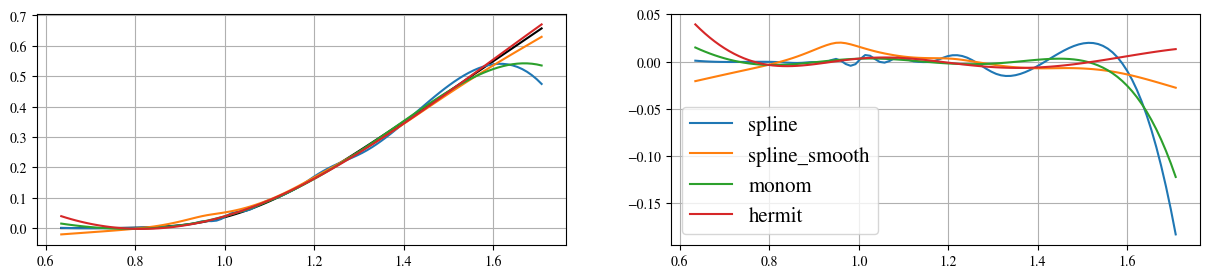

In [192]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
labels = ['spline', 'spline_smooth', 'monom', 'hermit']
ax[0].plot(xx, true, color='black')
ax[0].plot(xx, spline(xx))
ax[0].plot(xx, spline_smooth(xx))
ax[0].plot(xx, predict)
ax[0].plot(xx, predict_hermit)
ax[0].grid()

ax[1].plot(xx, spline(xx) - true)
ax[1].plot(xx, spline_smooth(xx) - true)
ax[1].plot(xx, predict - true)
ax[1].plot(xx, predict_hermit - true)
ax[1].grid()
ax[1].legend(labels, fontsize=15)
plt.show()

In [193]:
np.linalg.norm(spline(xx) - true), np.linalg.norm(spline_smooth(xx) - true)

(np.float64(0.3356003107128431), np.float64(0.11634285706835071))

In [194]:
np.linalg.norm(true - predict)

np.float64(0.247165279897349)

In [195]:
np.linalg.norm(true - predict_hermit)

np.float64(0.08772120482170263)

## Задача

Дамика цены и позиции:
$$
    dp_t = \mu dt + \sigma_p dW_t^p \\ 
    dq_t = u(t, q_t, p_t) dt + \sigma_q dW_t^q
$$

PnL:
$$
    dL_t = q_t dp_t - \dfrac{\nu}{2} u_t^2 dt 
$$

Ограничение: $|q_t| \leq q_{max}$

Выигрыш от стратегии $u$:
$$
    J(u) = \mathbb{E} \int_0^{\tau} e^{-r t} dL_t = 
    \mathbb{E} \int_0^{\tau}e^{-r t} \left(q_t \mu - \dfrac{\nu^2}{2} u_t^2\right) dt
$$где $\tau = \inf_{t \geq 0}\{|q_t| > q_{max}\}$

Оптимальная стратегия $u = u(q, p)$ в классе стационарных стратегий

Допустим $V = V(q)$:
$$
    \dfrac{\sigma^2}{2} V'' + q\mu + \dfrac{1}{2\nu} (V')^2 - rV = 0
$$
$V(-q_{max}) = V(q_{max}) = 0$

$u = \dfrac{V'}{\nu}$

$$
    F_n = \dfrac{\sigma^2}{2 h^2}(v_{n+1} - 2v_n + v_{n-1}) + q_n \mu + \dfrac{1}{8\nu h^2} (v_{n+1} - v_{n-1})^2 - r V_n
$$

##

$$V'' + \dfrac{2 q \mu}{\sigma^2} + (V')^2 \dfrac{1}{\sigma^2 \nu} - \dfrac{2r}{\sigma^2} V = 0$$

$$y = v'$$

$$
    y' = -\dfrac{2 q \mu}{\sigma^2} - y^2 \dfrac{1}{\sigma^2 \nu} + \dfrac{2r}{\sigma^2} v \\
    v' = y
$$

In [451]:
def cauchy_rhs(q, X, mu, sigma, nu, r):
    v, y = X
    
    res = np.r_[
        y,
        -2 * q * mu / sigma ** 2 - y ** 2 / (sigma ** 2 * nu) + 2 * r / sigma ** 2 * v
    ]
    
    return res

In [452]:
def rk4(xn, y, rhs, args):
    nsteps = len(xn)
    results = [y]
    for i in range(nsteps - 1):
        h = xn[i + 1] - xn[i]
        k1 = rhs(xn[i], y, *args)
        k2 = rhs(xn[i] + 0.5 * h, y + h * 0.5 * k1, *args)
        k3 = rhs(xn[i] + 0.5 * h, y + h * 0.5 * k2, *args)
        k4 = rhs(xn[i] + 1.0 * h, y + h * 1.0 * k1, *args)
        y = y + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        results.append(y)
    return np.array(results)

In [453]:
nq = 101
qn, hq = np.linspace(-qmax, qmax, nq, retstep=True)

x0 = np.r_[0, 0]
results = rk4(qn, x0, cauchy_rhs, (mu, sigma, nu, r))

In [458]:
def rhs(vn, qn, sigma, mu, nu, r):
    h = qn[1] - qn[0]
    dv_dq = np.zeros_like(qn)
    d2v_dq2 = np.zeros_like(qn)
    dv_dq[1:-1] = (vn[2:] - vn[:-2]) / (2 * h)
    d2v_dq2[1:-1] = (vn[2:] - 2 * vn[1:-1] +  vn[:-2]) / (h ** 2)
    res = 0.5 * sigma ** 2 * d2v_dq2 + qn * mu + 0.5 * (dv_dq) ** 2 / nu - r * vn
    res[0] = vn[0]
    res[-1] = vn[-1]
    return res


def jac(vn, qn, sigma, mu, nu, r):
    h = qn[1] - qn[0]
    n = len(vn)
    jac = np.zeros((n, n))
    jac[0, 0] = 1.0
    jac[-1, -1] = 1.0
    
    for i in range(1, n - 1):
        jac[i, i] = -(sigma / h) ** 2 - r
        jac[i, i + 1] = 0.5 * (sigma / h) ** 2 + 0.25 / (nu * h ** 2) * (vn[i + 1] - vn[i - 1])
        jac[i, i - 1] = 0.5 * (sigma / h) ** 2 - 0.25 / (nu * h ** 2) * (vn[i + 1] - vn[i - 1])
    return jac

In [494]:
sigma = 0.5
r = 0.1
mu = 0.5

qmax = 1.0
nu = 0.8

nq = 101
qn, hq = np.linspace(-qmax, qmax, nq, retstep=True)

args = qn, sigma, mu, nu, r

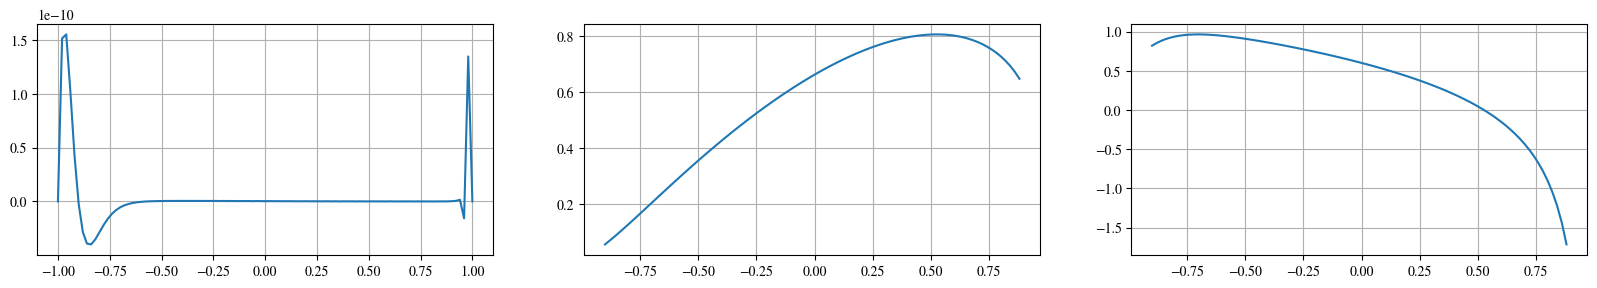

In [498]:
from scipy import optimize
res = optimize.root(rhs, x0=np.zeros_like(qn), args=args)
fun = rhs(res.x, *args)

mask = (qn >= -0.9) & (qn <= 0.9)
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax[0].plot(qn, fun)
ax[0].grid()

ax[1].plot(qn[mask], res.x[mask])
ax[1].grid()
u = np.gradient(res.x, qn, edge_order=2) / nu
ax[2].plot(qn[mask], u[mask])
ax[2].grid()
plt.show()

In [4]:
from tqdm import tqdm

In [28]:
nsims2 = np.r_[1, 4, 10, 20, 50, 100]

preds = []
preds_h = []
Ys = []

degree = 4

for nsim2 in tqdm(nsims2):
    Y = np.zeros(nsim)
    for j in range(nsim):
        sample = common.sample_gbm(tn[nt // 2:], nsim2, X[j], r, sigma, match=nsim2 > 2)
        Y[j] = np.exp(-r * 0.5 * T) * (sample[-1] - strike).clip(0.0).mean()
    Ys.append(Y)
    model = amc.PolynomialRegression(degree)
    model.fit(X, Y)

    model_hermit = amc.HermiteRegression(degree)
    model_hermit.fit(X, Y)
    
    preds.append(model.predict(xx))
    preds_h.append(model_hermit.predict(xx))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:29<00:00,  4.96s/it]


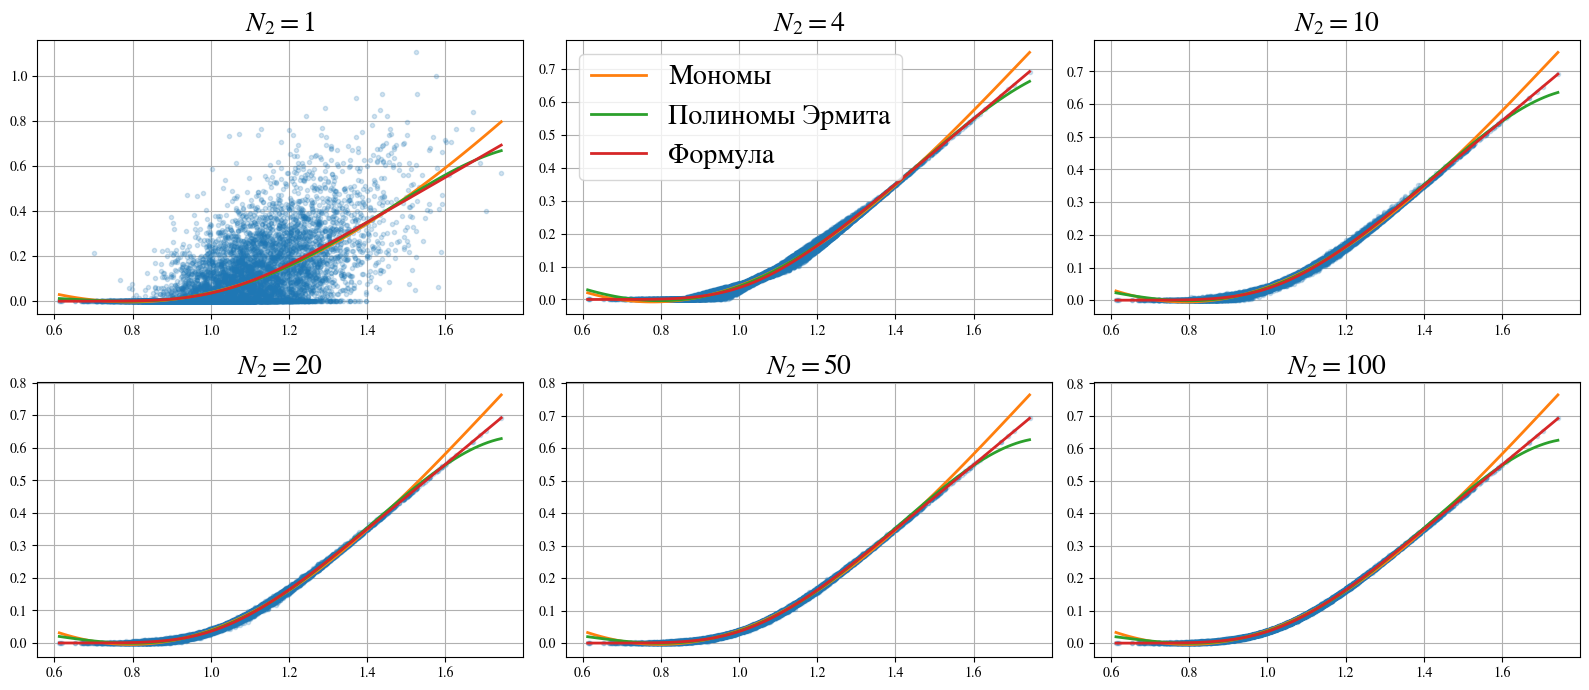

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7))
ax = ax.reshape(-1)

for i, nsim2 in enumerate(nsims2): 
    ax[i].plot(X, Ys[i], '.', alpha=0.2)
    ax[i].plot(xx, preds[i], lw=2, label='Мономы')
    ax[i].plot(xx, preds_h[i], lw=2, label='Полиномы Эрмита')
    ax[i].plot(xx, true, lw=2, label='Формула')
    #ax[i].legend(fontsize=15)
    ax[i].grid()
    ax[i].set_title(rf"$N_2={nsim2}$", fontsize=20)
ax[1].legend(fontsize=20)
fig.tight_layout()
fig.savefig('../12_figs/double_regression_based_mc_moment_matching.jpg')
plt.show()

In [30]:
nsims2 = np.r_[1, 4, 10, 20, 50, 100]

preds = []
preds_h = []
Ys = []

degree = 4

for nsim2 in tqdm(nsims2):
    Y = np.zeros(nsim)
    for j in range(nsim):
        sample = common.sample_gbm(tn[nt // 2:], nsim2, X[j], r, sigma, match=False)
        Y[j] = np.exp(-r * 0.5 * T) * (sample[-1] - strike).clip(0.0).mean()
    Ys.append(Y)
    model = amc.PolynomialRegression(degree)
    model.fit(X, Y)

    model_hermit = amc.HermiteRegression(degree)
    model_hermit.fit(X, Y)
    
    preds.append(model.predict(xx))
    preds_h.append(model_hermit.predict(xx))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:26<00:00,  4.35s/it]


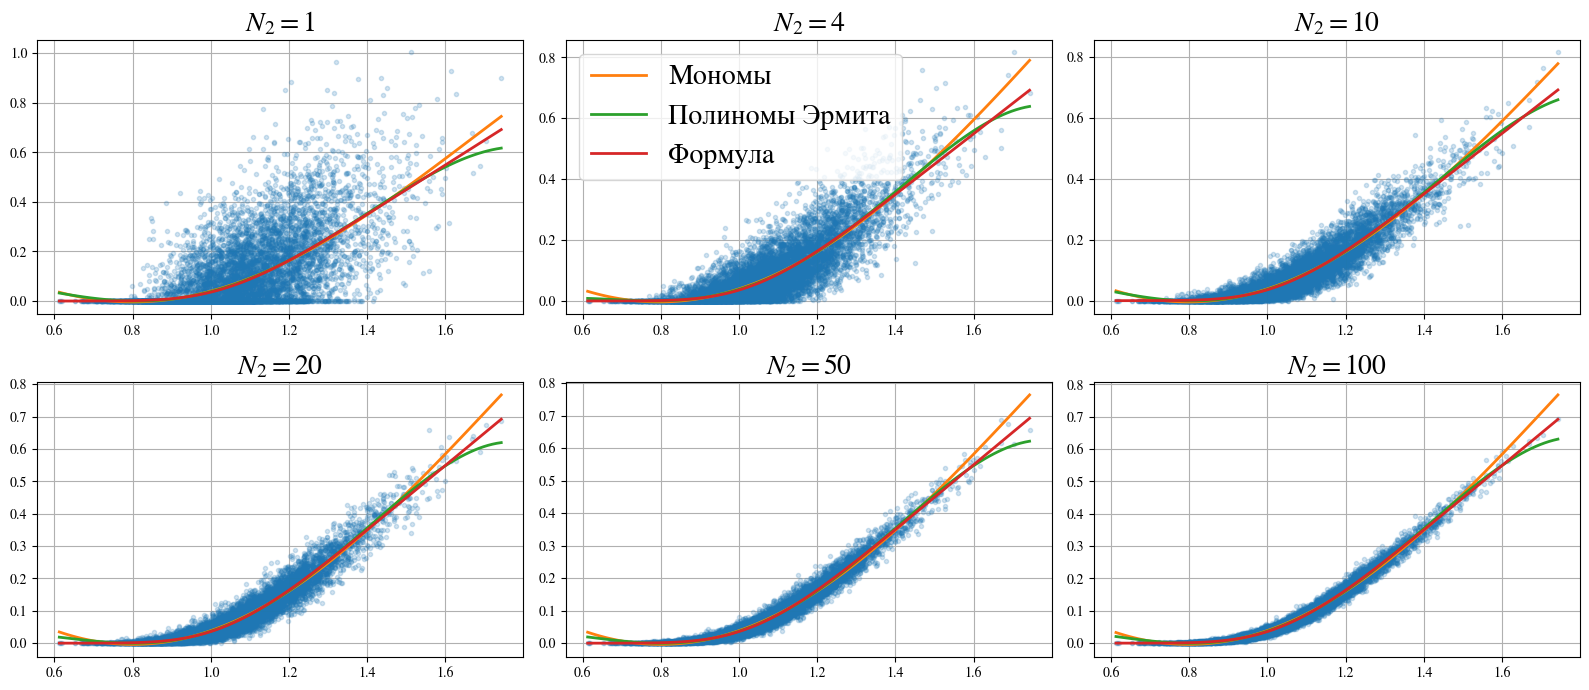

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7))
ax = ax.reshape(-1)

for i, nsim2 in enumerate(nsims2): 
    ax[i].plot(X, Ys[i], '.', alpha=0.2)
    ax[i].plot(xx, preds[i], lw=2, label='Мономы')
    ax[i].plot(xx, preds_h[i], lw=2, label='Полиномы Эрмита')
    ax[i].plot(xx, true, lw=2, label='Формула')
    #ax[i].legend(fontsize=15)
    ax[i].grid()
    ax[i].set_title(rf"$N_2={nsim2}$", fontsize=20)
ax[1].legend(fontsize=20)
fig.tight_layout()
fig.savefig('../12_figs/double_regression_based_mc.jpg')
plt.show()

In [160]:
spots = common.sample_gbm(tn, nsim, S, r, sigma)

features = spots.reshape(nt + 1, nsim, -1)
strikes = S * np.linspace(0.7, 1.5, 31)

results = []
degrees = [2, 3, 4, 5, 6, 8]
for degree in degrees:
    model_generator = lambda : amc.HermiteRegression(degree)
    prices = np.zeros_like(strikes)
    for i, strike in enumerate(tqdm(strikes, leave=False)):  
        # --------------------------------------------------------------------------------------------------------
        payoff = np.exp(-r * tn.reshape(-1, 1)) * (strike - spots).clip(0.0)
        fit_results = amc.fit_american_montecarlo(payoff, features, model_generator, POI=False, fit_itm=False)
        prices[i] = fit_results['price']
    results.append(prices)
results = np.array(results)

In [161]:
res_poi = np.zeros_like(strikes)
model_generator = lambda : amc.HermiteRegression(2)
for i, strike in enumerate(tqdm(strikes, leave=False)):  
    # --------------------------------------------------------------------------------------------------------
    payoff = np.exp(-r * tn.reshape(-1, 1)) * (strike - spots).clip(0.0)
    fit_results = amc.fit_american_montecarlo(payoff, features, model_generator, POI=True, fit_itm=True)
    res_poi[i] = fit_results['price']

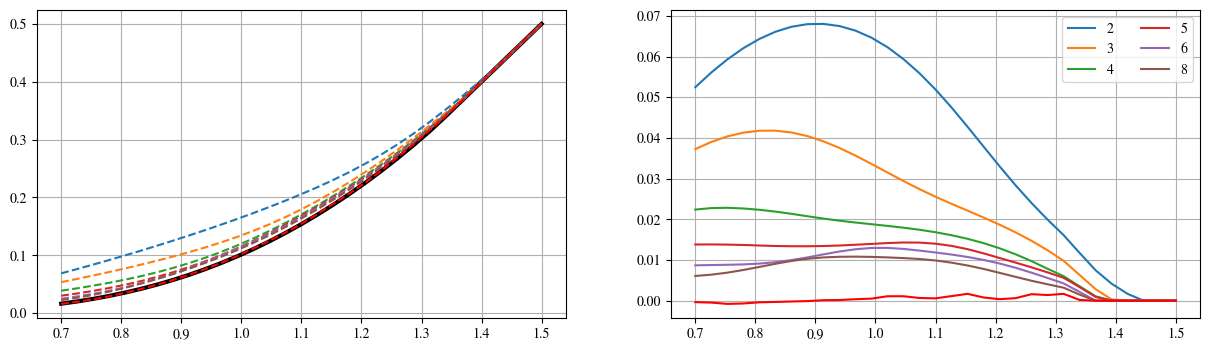

In [162]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(strikes, pde_prices, color='black', lw=3)
ax[0].plot(strikes, results.T, '--')
ax[0].plot(strikes, res_poi, '--', color='red')
ax[0].grid()
ax[1].plot(strikes, results.T - pde_prices.reshape(-1, 1))
ax[1].plot(strikes, res_poi - pde_prices, color='red')
ax[1].grid()
ax[1].legend(degrees, ncols=2)
plt.show()

In [126]:
from tqdm import tqdm
import pde

def get_price_pde(T, strike, r, sigma, nt, nx):
    payoff = lambda S: (strike - S).clip(0.0)
    phi_l = lambda t, S : strike * np.exp(-r * (T - t)) - S
    phi_r = lambda t, S : 0
    tn = np.linspace(0, T, nt + 1)
    B = 5 * sigma * np.sqrt(T)
    xn = np.linspace(-B, B, nx + 1)
    u = pde.get_option_price_implicit(xn, tn, r, sigma, False, payoff, phi_l, phi_r)
    return u[nx // 2]

def get_eb_tree(T, strike, r, sigma, nt, nx):
    payoff = lambda S: (strike - S).clip(0.0)
    phi_l = lambda t, S : strike * np.exp(-r * (T - t)) - S
    phi_r = lambda t, S : 0
    tn = np.linspace(0, T, nt + 1)
    B = 5 * sigma * np.sqrt(T)
    xn = np.linspace(-B, B, nx + 1)
    u = pde._get_option_price_implicit(xn, tn, r, sigma, False, payoff, phi_l, phi_r)
    
    eb = np.zeros_like(tn)
    for i in range(nt + 1):
        mask = u[i] > payoff(np.exp(xn))
        if len(np.where(mask)[0]):
            ind = np.where(mask)[0][0]
            eb[i] = np.exp(xn[ind])
        else:
            eb[i] = eb[i - 1]
    eb[-1] = strike
    return eb

In [127]:
T = 2
nt = 104
nsim = 10_000
tn = np.linspace(0, T, nt + 1)

S = 1
sigma = 0.3
r = 0.1

In [129]:
spots = common.sample_gbm(tn, nsim, S, r, sigma)
spots_ = common.sample_gbm(tn, nsim, S, r, sigma)

model_generator = lambda : amc.HermiteRegression(4)

features = spots.reshape(nt + 1, nsim, -1)
features_ = spots_.reshape(nt + 1, nsim, -1)
strikes = S * np.linspace(0.7, 1.5, 31)

results = {
    "vanilla" : {
        "fit" : np.zeros_like(strikes),
        "predict" : np.zeros_like(strikes),
        "lb" : np.zeros_like(strikes),
        "ub" : np.zeros_like(strikes)
    },
    "poi" : {
        "fit" : np.zeros_like(strikes),
        "predict" : np.zeros_like(strikes),
        "lb" : np.zeros_like(strikes),
        "ub" : np.zeros_like(strikes)
    },
    "fit_itm" : {
        "fit" : np.zeros_like(strikes),
        "predict" : np.zeros_like(strikes),
        "lb" : np.zeros_like(strikes),
        "ub" : np.zeros_like(strikes)
    }
}

for i, strike in enumerate(tqdm(strikes)):  
    # --------------------------------------------------------------------------------------------------------
    payoff = np.exp(-r * tn.reshape(-1, 1)) * (strike - spots).clip(0.0)
    fit_results = amc.fit_american_montecarlo(payoff, features, model_generator, POI=False, fit_itm=False)
    results['vanilla']['fit'][i] = fit_results['price']
    results['vanilla']['ub'][i] = fit_results['upper_bound']
    results['vanilla']['lb'][i] = fit_results['lower_bound']
    
    payoff = np.exp(-r * tn.reshape(-1, 1)) * (strike - spots_).clip(0.0)
    predict_results = amc.predict_american_montecarlo(payoff, features_, fit_results['model'])
    results['vanilla']['predict'][i] = predict_results['price']
    
    # --------------------------------------------------------------------------------------------------------
    payoff = np.exp(-r * tn.reshape(-1, 1)) * (strike - spots).clip(0.0)
    fit_results = amc.fit_american_montecarlo(payoff, features, model_generator, POI=True, fit_itm=False)
    results['poi']['fit'][i] = fit_results['price']
    results['poi']['ub'][i] = fit_results['upper_bound']
    results['poi']['lb'][i] = fit_results['lower_bound']
    
    payoff = np.exp(-r * tn.reshape(-1, 1)) * (strike - spots_).clip(0.0)
    predict_results = amc.predict_american_montecarlo(payoff, features_, fit_results['model'])
    results['poi']['predict'][i] = predict_results['price']

    # --------------------------------------------------------------------------------------------------------
    payoff = np.exp(-r * tn.reshape(-1, 1)) * (strike - spots).clip(0.0)
    fit_results = amc.fit_american_montecarlo(payoff, features, model_generator, POI=True, fit_itm=True)
    results['fit_itm']['fit'][i] = fit_results['price']
    results['fit_itm']['ub'][i] = fit_results['upper_bound']
    results['fit_itm']['lb'][i] = fit_results['lower_bound']
    
    payoff = np.exp(-r * tn.reshape(-1, 1)) * (strike - spots_).clip(0.0)
    predict_results = amc.predict_american_montecarlo(payoff, features_, fit_results['model'])
    results['fit_itm']['predict'][i] = predict_results['price']

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [01:09<00:00,  2.25s/it]


In [130]:
pde_prices = [get_price_pde(T, strike, r, sigma, nt, 5000) for strike in tqdm(strikes)]
pde_prices = np.array(pde_prices)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.76it/s]


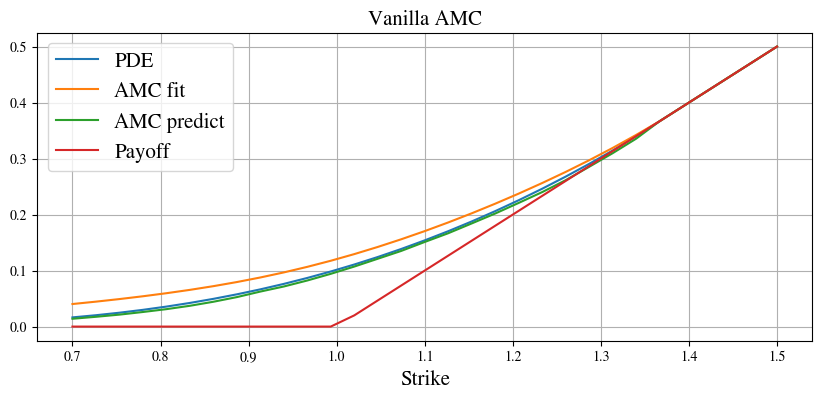

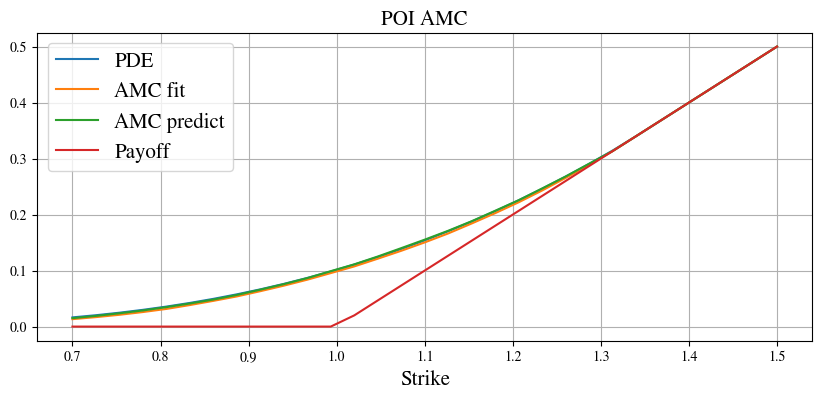

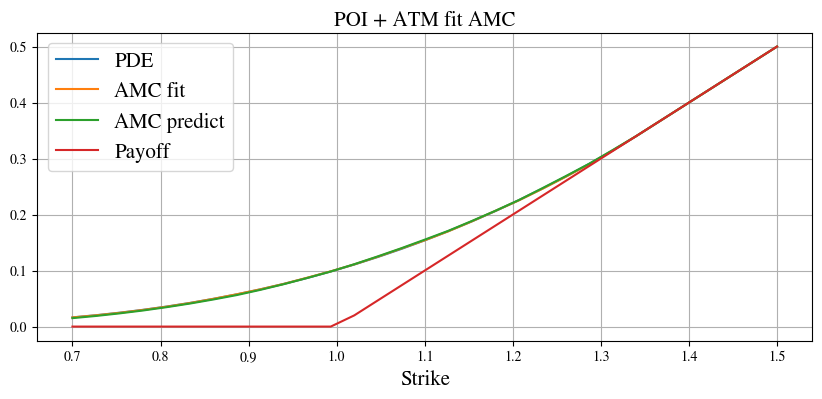

In [131]:
fig = plt.figure(figsize=(10, 4))
plt.title("Vanilla AMC", fontsize=15)
plt.plot(strikes, pde_prices, label='PDE')
plt.plot(strikes, results['vanilla']['fit'], label='AMC fit')
plt.plot(strikes, results['vanilla']['predict'], label='AMC predict')
plt.plot(strikes, (strikes - S).clip(0.0), label='Payoff')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=15)
#fig.savefig('../12_figs/amc_vanilla.jpg')
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("POI AMC", fontsize=15)
plt.plot(strikes, pde_prices, label='PDE')
plt.plot(strikes, results['poi']['fit'], label='AMC fit')
plt.plot(strikes, results['poi']['predict'], label='AMC predict')
plt.plot(strikes, (strikes - S).clip(0.0), label='Payoff')
plt.legend(fontsize=15)
plt.grid()
#fig.savefig('../12_figs/amc_poi.jpg')
plt.xlabel("Strike", fontsize=15)
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("POI + ATM fit AMC", fontsize=15)
plt.plot(strikes, pde_prices, label='PDE')
plt.plot(strikes, results['fit_itm']['fit'], label='AMC fit')
plt.plot(strikes, results['fit_itm']['predict'], label='AMC predict')
plt.plot(strikes, (strikes - S).clip(0.0), label='Payoff')
plt.legend(fontsize=15)
plt.grid()
#fig.savefig('../12_figs/amc_fit_atm.jpg')
plt.xlabel("Strike", fontsize=15)
plt.show()

In [101]:
nsims = 1000 * (2 ** np.arange(10))

results_nsim = {
    "vanilla" : {
        "fit" : np.zeros_like(nsims, np.float64),
        "predict" : np.zeros_like(nsims, np.float64),
    },
    "poi" : {
        "fit" : np.zeros_like(nsims, np.float64),
        "predict" : np.zeros_like(nsims, np.float64),
    }
}

for i, nsim in enumerate(tqdm(nsims)):
    spots = common.sample_gbm(tn, nsim, S, r, sigma)
    spots_ = common.sample_gbm(tn, nsim, S, r, sigma)

    model_generator = lambda : amc.PolynomialRegression(4)

    features = spots.reshape(nt + 1, nsim, -1)
    features_ = spots_.reshape(nt + 1, nsim, -1)
    strike = S * np.exp(tn[-1] * r)

    # --------------------------------------------------------------------------------------------------------
    payoff = np.exp(-r * tn.reshape(-1, 1)) * (strike - spots).clip(0.0)
    fit_results = amc.fit_american_montecarlo(payoff, features, model_generator, POI=False, fit_itm=False)
    results_nsim['vanilla']['fit'][i] = fit_results['price']
    
    payoff = np.exp(-r * tn.reshape(-1, 1)) * (strike - spots_).clip(0.0)
    predict_results = amc.predict_american_montecarlo(payoff, features_, fit_results['model'])
    results_nsim['vanilla']['predict'][i] = predict_results['price']

    # --------------------------------------------------------------------------------------------------------
    payoff = np.exp(-r * tn.reshape(-1, 1)) * (strike - spots).clip(0.0)
    fit_results = amc.fit_american_montecarlo(payoff, features, model_generator, POI=True, fit_itm=True)
    results_nsim['poi']['fit'][i] = fit_results['price']
    
    payoff = np.exp(-r * tn.reshape(-1, 1)) * (strike - spots_).clip(0.0)
    predict_results = amc.predict_american_montecarlo(payoff, features_, fit_results['model'])
    results_nsim['poi']['predict'][i] = predict_results['price']

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:55<00:00, 11.58s/it]


In [114]:
pde_atm_price =get_price_pde(T, S * np.exp(r * T), r, sigma, nt, 5000)

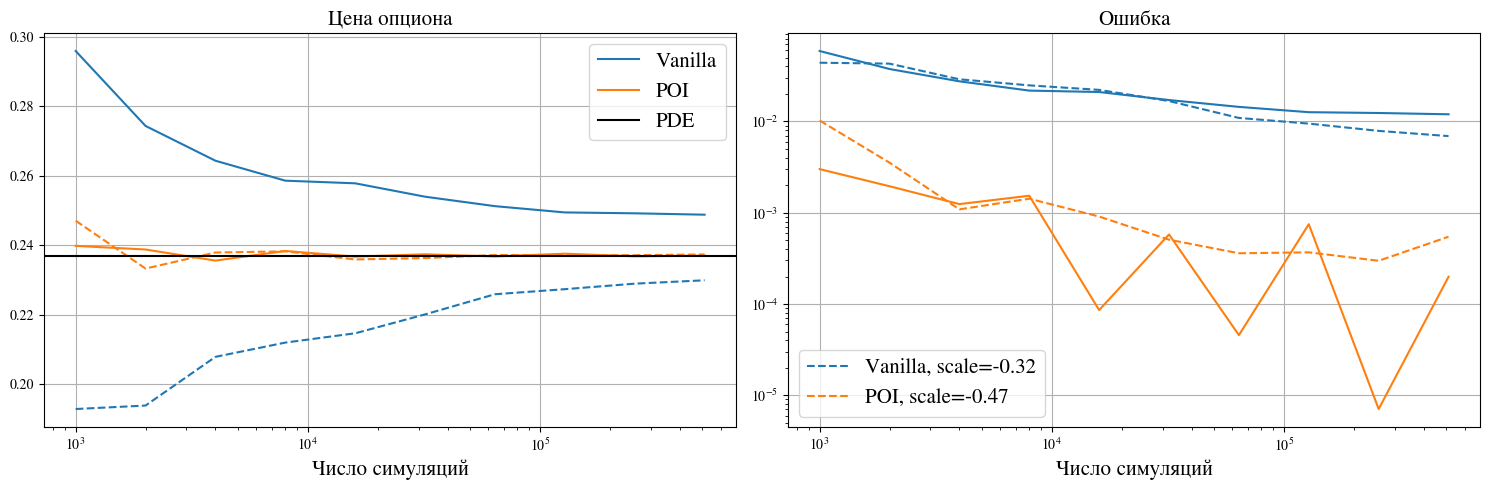

In [141]:
fig, ax = plt.subplots(1, 2, figsize=(15,  5))

ax[0].set_title("Цена опциона", fontsize=15)
ax[0].semilogx(nsims, results_nsim['vanilla']['fit'], '-', color='C0', label='Vanilla')
ax[0].semilogx(nsims, results_nsim['vanilla']['predict'], '--', color='C0')
ax[0].semilogx(nsims, results_nsim['poi']['fit'], '-', color='C1', label='POI')
ax[0].semilogx(nsims, results_nsim['poi']['predict'], '--', color='C1')
ax[0].axhline(pde_atm_price, color='black', label='PDE')
ax[0].grid()
ax[0].legend(fontsize=15)
ax[0].set_xlabel("Число симуляций", fontsize=15)

ax[1].set_title("Ошибка", fontsize=15)
error = np.abs(results_nsim['vanilla']['fit'] - pde_atm_price)
ax[1].loglog(nsims, error, '-', color='C0')
error = np.abs(results_nsim['vanilla']['predict'] - pde_atm_price)
x, y = np.log(nsims), np.log(error)
scale, _ = np.polyfit(x, y, 1)
ax[1].loglog(nsims, error, '--', color='C0', label=f'Vanilla, scale={scale:0.2f}')
error = np.abs(results_nsim['poi']['fit'] - pde_atm_price)
ax[1].loglog(nsims, error, '-', color='C1', )
error = np.abs(results_nsim['poi']['predict'] - pde_atm_price)
x, y = np.log(nsims), np.log(error)
scale, _ = np.polyfit(x, y, 1)
ax[1].loglog(nsims, error, '--', color='C1', label=f'POI, scale={scale:0.2f}')
ax[1].grid()
ax[1].set_xlabel("Число симуляций", fontsize=15)
ax[1].legend(fontsize=15)
fig.tight_layout()
fig.savefig('../12_figs/amc_error.jpg')
plt.show()

In [176]:
eb_tree = get_eb_tree(T, S * np.exp(r * T), r, sigma, nt, 5000)

In [138]:
degrees = [2, 4, 6, 8]
ebs = []
df = np.exp(-r * (tn[1] - tn[0]))
for degree in tqdm(degrees):
    model_generator = lambda : amc.PolynomialRegression(degree)
    payoff = (strike - spots).clip(0.0)
    fit_results = amc.fit_american_montecarlo(payoff, features, model_generator, POI=True, fit_itm=True, df=df)
    taus = fit_results['expiration_date']
    eb = np.zeros_like(tn)
    for t in range(nt + 1):
        mask = (taus == t)
        eb[t] = spots[t, mask].mean()
    ebs.append(eb)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\Alex\AppData\Local\Temp\ipykernel_17080\380906257.py:12: RuntimeWarning: Mean of empty slice.
  eb[t] = spots[t, mask].mean()
C:\Users\Alex\miniconda3\envs\venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 25%|█████████████████████                                                               | 1/4 [00:02<00:08,  2.74s/it]C:\Users\Alex\AppData\Local\Temp\ipykernel_17080\380906257.py:12: RuntimeWarning: Mean of empty slice.
  eb[t] = spots[t, mask].mean()
C:\Users\Alex\miniconda3\envs\venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 50%|██████████████████████████████████████████                                          | 2/4 [00:05<00:05,  2.92s/it]C:\Users\Alex\App

In [141]:
ebs = np.array(ebs)

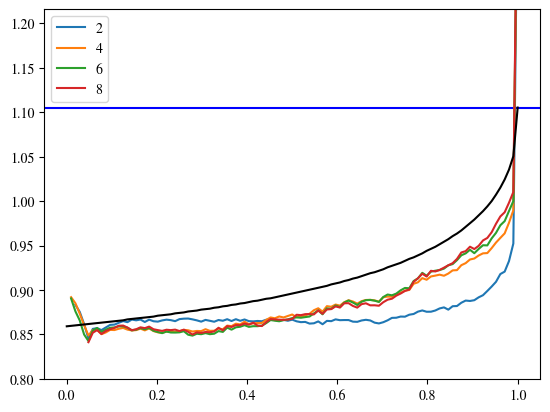

In [142]:
plt.axhline(strike, color='blue')
plt.plot(tn, ebs.T, label=degrees)
plt.plot(tn, eb_tree, color='black')
plt.ylim(0.8, strike * 1.1)
plt.legend()

In [32]:
def sample_bridge(tn, nsim):
    nt = len(tn) - 1
    bm = common.sample_bm(tn, nsim)
    res = bm  - bm[-1:] * tn.reshape(-1, 1) / tn[-1]
    return res

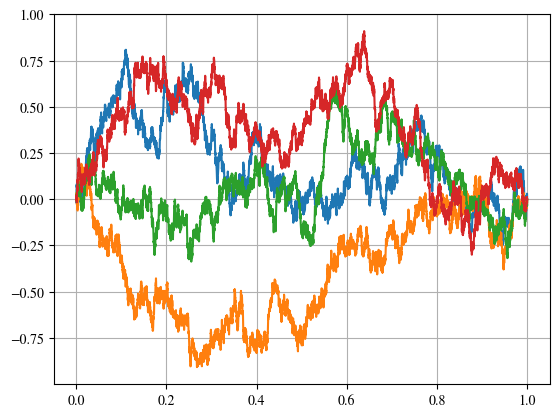

In [33]:
tn = np.linspace(0, 1, 10001)
bridge = sample_bridge(tn, 4)

plt.plot(tn, bridge)
plt.grid()
plt.show()

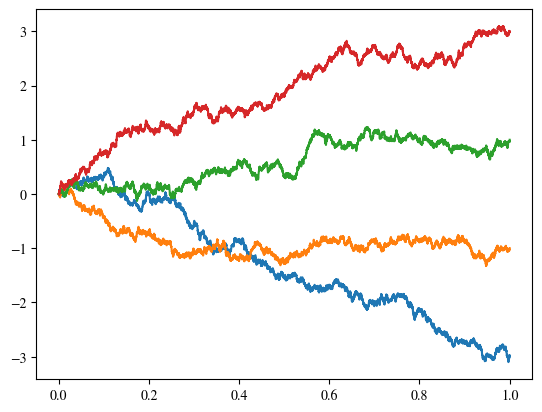

In [34]:
finals = np.r_[-3, -1, 1, 3]
means = tn.reshape(-1, 1) * finals.reshape(1, -1)
plt.plot(tn, means + bridge)

In [35]:
spots = np.exp(sigma * (bridge + means))

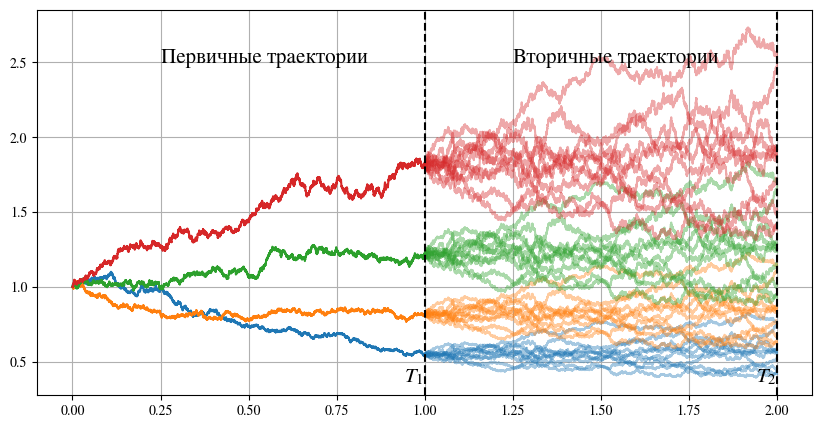

In [55]:
fig = plt.figure(figsize=(10, 5))
plt.plot(tn, spots)
for i in range(4):
    np.random.seed(42)
    samples = common.sample_gbm(tn, 10, spots[-1, i], 0.5 * sigma ** 2, sigma)
    plt.plot(tn + 1.0, samples, color=f'C{i}', alpha=0.4)
plt.axvline(1.0, color='black', linestyle='--')
plt.axvline(2.0, color='black', linestyle='--')
plt.text(1.0 - 0.06, 0.35 + 0.01,  r'$T_1$', fontsize=15)
plt.text(2.0 - 0.06, 0.35 + 0.01, r'$T_2$', fontsize=15)
plt.text(0.25, 2.5, "Первичные траектории", fontsize=15)
plt.text(1.25, 2.5, "Вторичные траектории", fontsize=15)
plt.grid()
fig.savefig('../12_figs/double_mc.jpg')

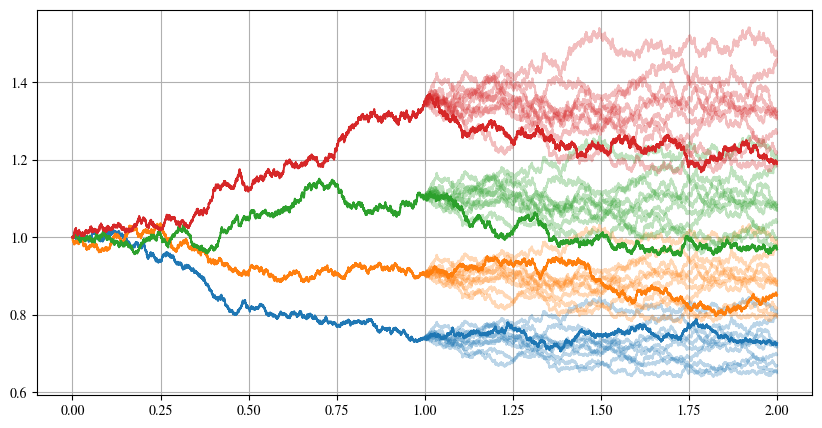

In [150]:
plt.figure(figsize=(10, 5))
plt.plot(tn, spots)
for i in range(4):
    np.random.seed(42)
    samples = sample_gbm(tn, 10, spots[-1, i], 0.5 * sigma ** 2, sigma)
    plt.plot(tn + 1.0, samples, color=f'C{i}', alpha=0.3)
    plt.plot(tn + 1.0, samples[:, i], color=f'C{i}')
plt.grid()

In [143]:
T = 1
nt = 104
nsim = 100_000
tn = np.linspace(0, T, nt + 1)

S = 1
sigma = 0.3
r = 0.1

strike =  S * np.exp(r * T)

In [144]:
spots = common.sample_gbm(tn, nsim, S, r, sigma)
spots_ = common.sample_gbm(tn, nsim, S, r, sigma)

features = spots
features_ = spots_

In [145]:
eb_tree = get_eb_tree(T, strike, r, sigma, nt, 5000)

In [152]:
degrees = [8, 10]
ebs = []
df = np.exp(-r * (tn[1] - tn[0]))
for degree in tqdm(degrees):
    model_generator = lambda : amc.PolynomialRegression(degree)
    payoff = (strike - spots).clip(0.0)
    fit_results = amc.fit_american_montecarlo(payoff, features, model_generator, POI=True, fit_itm=True, df=df)
    taus = fit_results['expiration_date']
    eb = np.zeros_like(tn)
    for t in range(nt + 1):
        mask = (taus == t)
        eb[t] = np.median(spots[t, mask])
    ebs.append(eb)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]C:\Users\Alex\miniconda3\envs\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Alex\miniconda3\envs\venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 50%|██████████████████████████████████████████                                          | 1/2 [00:05<00:05,  5.33s/it]C:\Users\Alex\miniconda3\envs\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Alex\miniconda3\envs\venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████

In [153]:
ebs = np.array(ebs)

In [157]:
xx = np.linspace(0.8, strike, 101)
models = fit_results['model']
eb_model = np.zeros_like(tn)
for t in range(nt + 1):
    try:
        cv = models[t].predict(xx)
        payoff = (strike - xx).clip(0.0)
        index = np.where(cv - payoff >= 0)[0][0]
        eb_model[t] = xx[index]
    except:
        eb_model[t] = eb_model[t - 1]

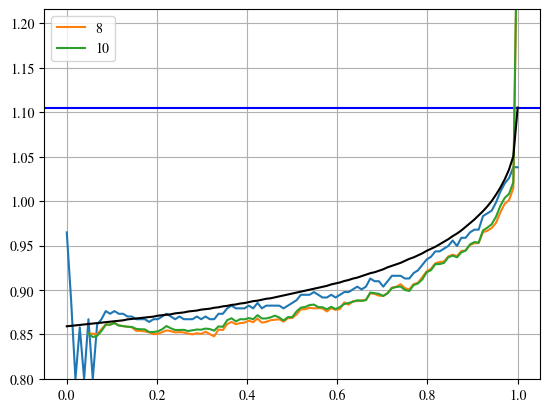

In [160]:
plt.plot(tn, eb_model)

plt.axhline(strike, color='blue')
plt.plot(tn, ebs.T, label=degrees)
plt.plot(tn, eb_tree, color='black')
plt.ylim(0.8, strike * 1.1)
plt.legend()

plt.grid()
plt.show()

In [294]:
from tqdm import tqdm
import pde

def get_price_pde(T, strike, r, sigma, nt, nx):
    payoff = lambda S: (strike - S).clip(0.0)
    phi_l = lambda t, S : strike - S
    phi_r = lambda t, S : 0
    tn = np.linspace(0, T, nt + 1)
    B = 5 * sigma * np.sqrt(T)
    xn = np.linspace(-B, B, nx + 1)
    u = pde.get_option_price_implicit(xn, tn, r, sigma, False, payoff, phi_l, phi_r)
    return u[nx // 2]

def get_price_pde_barrier(T, strike, barrier, r, sigma, nt, nx):
    payoff = lambda S: (strike - S).clip(0.0) * (S < barrier)
    phi_l = lambda t, S : strike * np.exp(-r * (T - t)) - S
    phi_r = lambda t, S : 0
    tn = np.linspace(0, T, nt + 1)
    B = 5 * sigma * np.sqrt(T)
    xn1 = np.linspace(-B, 0, nx // 2)
    xn2 = np.linspace(0, np.log(barrier), nx // 2)
    xn = np.r_[xn1, xn2[1:]]
    u = pde.get_option_price_implicit(xn, tn, r, sigma, True, payoff, phi_l, phi_r)
    #return xn, u
    return u[nx // 2]

In [295]:
get_price_pde(T, S * np.exp(r * T), r, sigma, 10000, 10000)

np.float64(0.14191514215463824)

In [296]:
fit_results['price']

np.float64(0.1419201669436091)

In [290]:
barrier = S * 1.2
strikes = np.linspace(0.7 * S, 1.5 * S, 101)
prices1 = np.array([get_price_pde_barrier(T, strike, 1.1, r, sigma, nt, 10000) for strike in strikes])
prices2 = np.array([get_price_pde_barrier(T, strike, 1.5, r, sigma, nt, 10000) for strike in strikes])
prices3 = np.array([get_price_pde_barrier(T, strike, 2, r, sigma, nt, 10000) for strike in strikes])
prices4 = np.array([get_price_pde_barrier(T, strike, 3, r, sigma, nt, 10000) for strike in strikes])
prices_vanilla = np.array([get_price_pde(T, strike, r, sigma, nt, 10000) for strike in strikes])

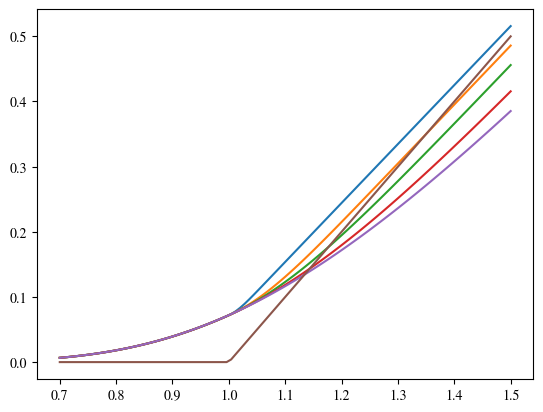

In [291]:
plt.plot(strikes, prices1)
plt.plot(strikes, prices2)
plt.plot(strikes, prices3)
plt.plot(strikes, prices4)
plt.plot(strikes, prices_vanilla)
plt.plot(strikes, (strikes - S).clip(0.0))

In [187]:
np.exp(5 * sigma * np.sqrt(T))

np.float64(4.4816890703380645)